In [1]:
# Packages 
import hddm
import sys
sys.path.append('..')
import paths
import tool
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os 
import seaborn as sns
from importlib import reload
#reload(paths)
#reload(paths)
import arviz as az
import matplotlib.cbook as cbook
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter


from pathlib import Path

/home/malthe/Documents/git/The-respiratory-cycle-modulates-distinct-dynamics-of-affective-and-perceptual-decision-making


In [2]:
# path to save models

RDM_loc = str(paths.rdm_models)+'/'
FAD_loc = str(paths.fad_models)+'/'

# Load models

In [3]:
os.chdir(RDM_loc)
RDM_models = tool.loadModels(None, RDM_loc, '15_RDM_base_10000_2000_2_4' )
RDM_sortet = tool.sort_models(RDM_models, ['RDM'])
tool.gelman_rubin(RDM_sortet)
RDM_model= tool.combine_models(RDM_sortet)
os.chdir(paths.HDDM)


min max GR: (0.999884637753184, 1.0030557023500635)


In [4]:
os.chdir(FAD_loc)
FAD_models = tool.loadModels(None, FAD_loc, '15_FAD_base_10000_2000_2_4' )
FAD_sortet = tool.sort_models(FAD_models, ['FAD'])
tool.gelman_rubin(FAD_sortet)
FAD_model= tool.combine_models(FAD_sortet)
os.chdir(paths.HDDM)


min max GR: (0.9998793026724696, 1.0007261009943667)


# Respiratory deltas

Get the MCMC data from the models

In [5]:
a_FAD,t_FAD, z_FAD= FAD_model.nodes_db.node[['a_C(state, Treatment(0))[T.1]', 
                                                                   't_C(state, Treatment(0))[T.1]',
                                                                   'z_C(state, Treatment(0))[T.1]',
                                                                   ]]
state_emo0, state_emo1, state_emo2, state_emo3 = FAD_model.nodes_db.node[[f'v_C(emotion, Treatment(0))[{0}]:C(state, Treatment(0))[T.1]',
                                                                                        f'v_C(emotion, Treatment(0))[{1}]:C(state, Treatment(0))[T.1]',
                                                                                        f'v_C(emotion, Treatment(0))[{2}]:C(state, Treatment(0))[T.1]',
                                                                                        f'v_C(emotion, Treatment(0))[{3}]:C(state, Treatment(0))[T.1]']]


a_RDM,t_RDM, z_RDM = RDM_model.nodes_db.node[['a_C(state, Treatment(0))[T.1]', 
                                                                   't_C(state, Treatment(0))[T.1]',
                                                                   'z_C(state, Treatment(0))[T.1]',
                                                                   ]]
up, down = RDM_model.nodes_db.node[['v_C(stim, Treatment(0))[1]:C(state, Treatment(0))[T.1]', 'v_C(stim, Treatment(0))[0]:C(state, Treatment(0))[T.1]']]


Calculate 95% highest posterior density interval (HPDI) and P-values

In [6]:
for delta in [up, down, a_RDM,t_RDM, z_RDM, state_emo0, state_emo1, state_emo2, state_emo3, a_FAD,t_FAD, z_FAD]:
    hdi = az.hdi(delta.trace(), hdi_prob=0.95)
    over = (delta.trace()>0).mean()
    under = (delta.trace()<0).mean()
    P = over if over < under else under
    P *= 2
    print(str(delta)[0], round(hdi[0],3), round(hdi[1],3), round(P,3))
    if ']:' in str(delta):
        print(str(delta))

v -0.288 -0.037 0.013
v_C(stim, Treatment(0))[1]:C(state, Treatment(0))[T.1]
v -0.111 0.135 0.889
v_C(stim, Treatment(0))[0]:C(state, Treatment(0))[T.1]
a -0.064 -0.011 0.008
t -0.008 0.003 0.376
z -0.003 0.027 0.122
v -0.216 0.078 0.341
v_C(emotion, Treatment(0))[0]:C(state, Treatment(0))[T.1]
v -0.249 0.032 0.119
v_C(emotion, Treatment(0))[1]:C(state, Treatment(0))[T.1]
v -0.211 0.073 0.323
v_C(emotion, Treatment(0))[2]:C(state, Treatment(0))[T.1]
v -0.056 0.221 0.236
v_C(emotion, Treatment(0))[3]:C(state, Treatment(0))[T.1]
a -0.037 0.013 0.35
t -0.006 0.004 0.556
z -0.0 0.028 0.048


# Paper fig. 3D
Posterior predictive distributions

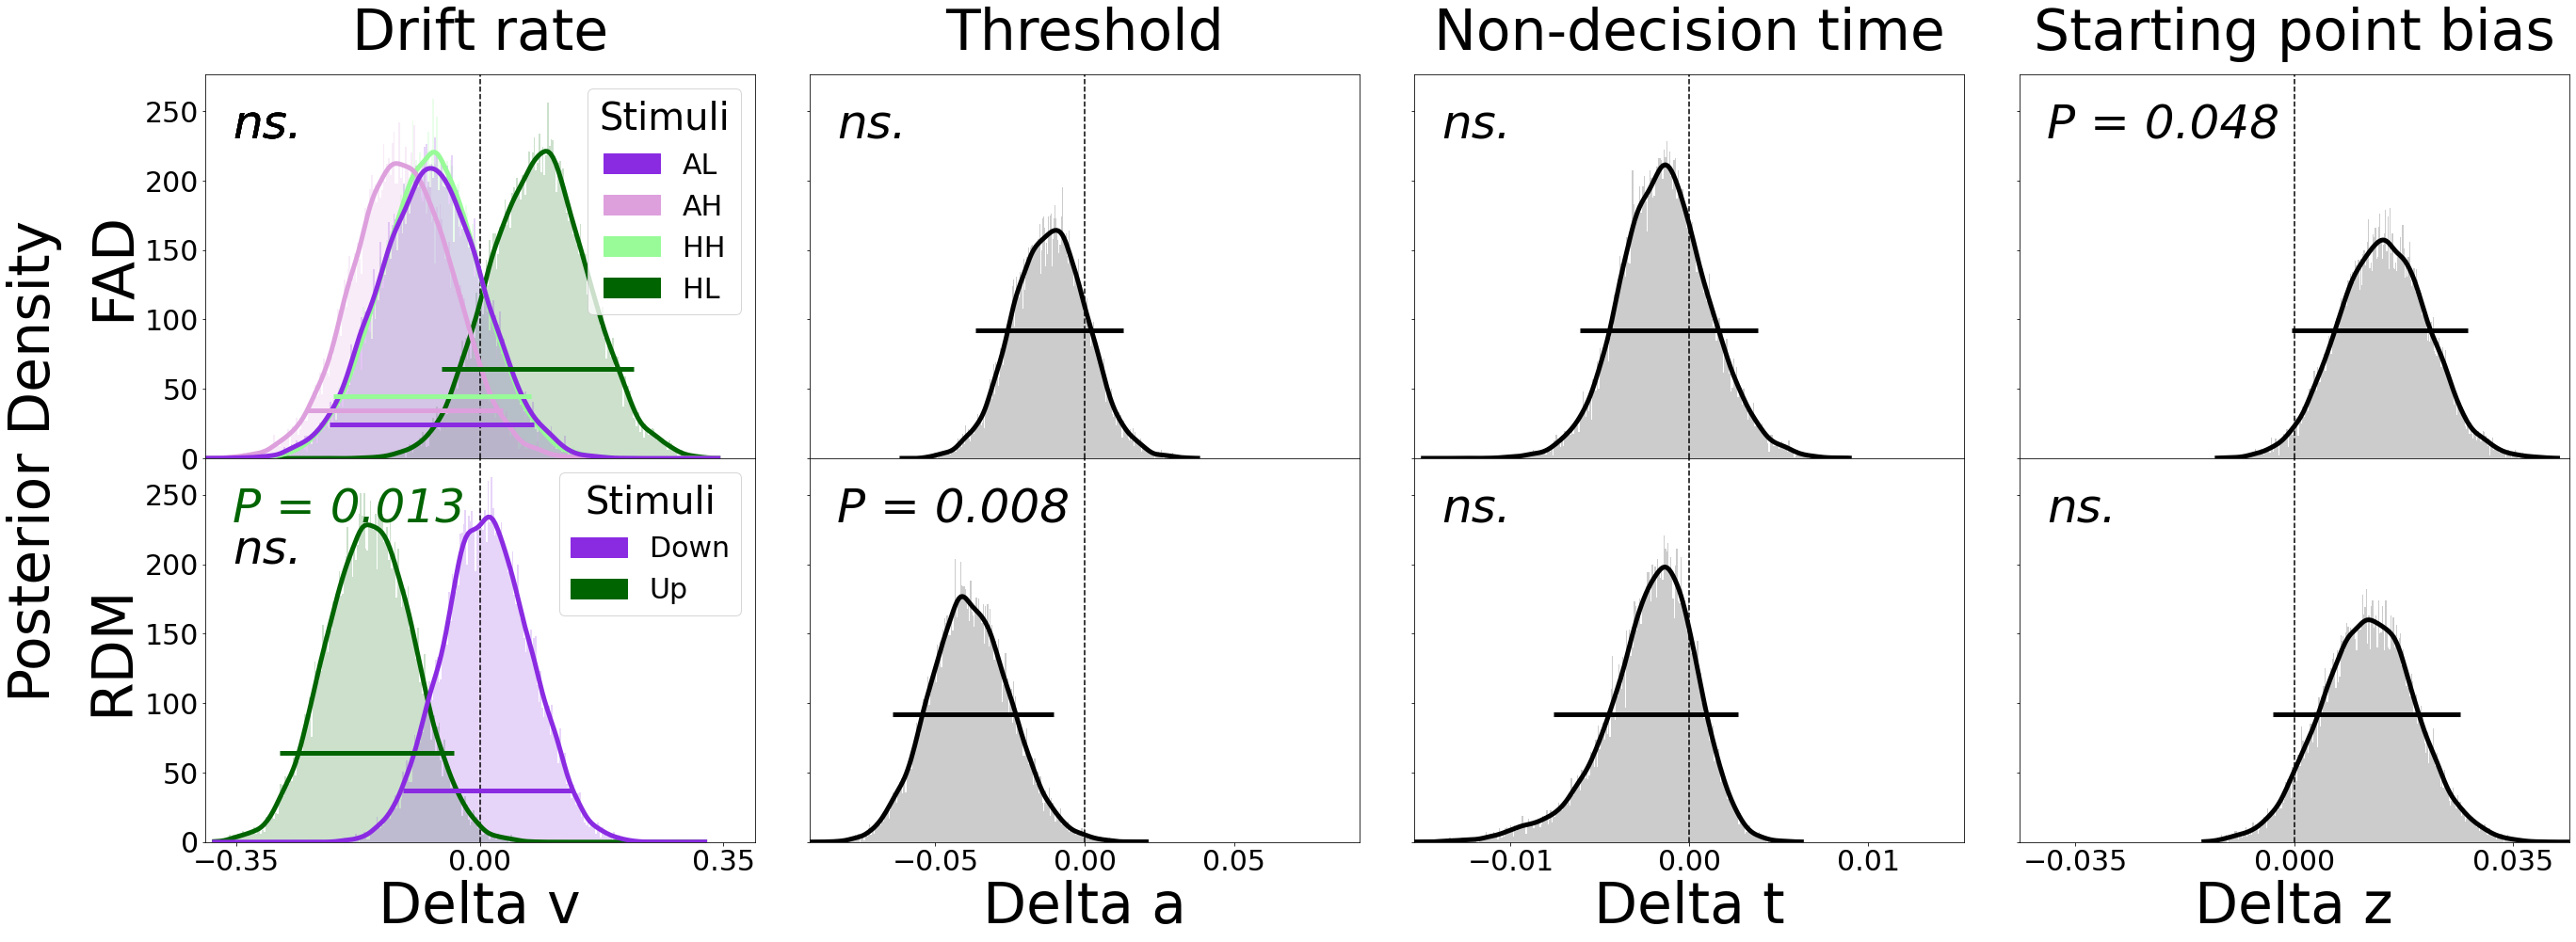

In [7]:
fig, axes = plt.subplots(2,4,  figsize=(45, 15), sharey=True, sharex='col',
gridspec_kw={ 'wspace':0.1, 'hspace':0.0})
fig.text(0.06, 0.5, 'Posterior Density', va='center', rotation='vertical', size=60)
axes[0,0].tick_params(labelsize=30)
for i in range(4):
    axes[1,i].tick_params(labelsize=30)

axes[0,0].set_ylabel('FAD', size=60)
axes[1,0].set_ylabel('RDM', size=60)


alpha = 0.2
linewidth= 0.001
linewidth_kde = 5
bins=300
params = ['v','a','t','z','sv']
param_names = {'v':'Drift rate', 't':'Non-decision time', 'a':'Threshold', 'sv':'Drift rate variability',
               'z':'Starting point bias'}

for FAD, RDM, col, p in zip([None, a_FAD,t_FAD, z_FAD ],[None, a_RDM,t_RDM, z_RDM], range(4), params[0:4]):
    for row in range(fig.axes[0].get_subplotspec().get_gridspec().get_geometry()[0]):
        axes[row,col].axvline(x=0, c='k', linestyle='--')

    if p == 'v':
        #for e in [state_emo0, state_emo1, state_emo2, state_emo3]:
        sns.histplot([state_emo0.trace(), state_emo1.trace(), state_emo2.trace(), state_emo3.trace()] , line_kws={'linewidth':linewidth_kde},
                bins=bins, ax=axes[0,col],  kde=True, alpha=alpha, linewidth=linewidth, palette=['blueviolet', 'plum', 'palegreen', 'darkgreen'])
        sns.histplot( [down.trace(), up.trace()], line_kws={'linewidth':linewidth_kde},
                bins=bins, ax=axes[1,col],  kde=True, alpha=alpha, linewidth=linewidth, palette= ['blueviolet', 'darkgreen']);
        
        # legend = axes[1,col].get_legend()
        # handles = legend.legendHandles
        # legend.remove()
        # axes[1,col].legend(handles, ['Down', 'Up', ], title='Stiuli')
        
        # legend = axes[0,col].get_legend()
        # handles = legend.legendHandles
        # legend.remove()
        # axes[0,col].legend(handles, ['AL', 'AH', 'HH', 'HL'], title='Stiuli')
        
        legendss = [['AL', 'AH', 'HH', 'HL'], ['Down', 'Up', ]]
        vcols = [['blueviolet', 'plum', 'palegreen', 'darkgreen'], ['blueviolet', 'darkgreen']]
        for legends, vcol, row in zip(legendss, vcols, [0,1]):
            leg = []
            for l, c in zip(legends, vcol):
                leg.append(mpatches.Patch(color=c, label=l))
                
            axes[row,col].legend(handles=leg, loc='upper right', title='Stimuli',
                                 #fontsize='xx-large',
                                 title_fontsize=40,
                                 prop={'size': 30}) 

        
        max_abs = np.max(np.array([np.max(np.abs(state_emo0.trace())),
                                  np.max(np.abs(state_emo1.trace())),
                                  np.max(np.abs(state_emo2.trace())),
                                  np.max(np.abs(state_emo3.trace())),
                                  np.max(np.abs(up.trace())),
                                  np.max(np.abs(down.trace()))]))
        axes[0,col].set_xlim(-max_abs, max_abs)
        axes[1,col].set_xlim(-max_abs, max_abs)
        
       
        axes[1,col].set_xticks([-max_abs,-max_abs/2,0, max_abs/2, max_abs])
        
        emo0 = az.hdi(state_emo0.trace(), hdi_prob=0.95)
        l, h = axes[0,col].get_ylim()
        yLoc = l + (h-l)/3 - (h-l)/10 -40
        axes[0,col].hlines(yLoc, emo0[0], emo0[1], color='blueviolet', zorder=100, linewidth=linewidth_kde)
        
        emo1 = az.hdi(state_emo1.trace(), hdi_prob=0.95)
        l, h = axes[0,col].get_ylim()
        yLoc = l + (h-l)/3 - (h-l)/10-30
        axes[0,col].hlines(yLoc, emo1[0], emo1[1], color='plum', zorder=100, linewidth=linewidth_kde)
        
        emo2 = az.hdi(state_emo2.trace(), hdi_prob=0.95)
        l, h = axes[0,col].get_ylim()
        yLoc = l + (h-l)/3 - (h-l)/10-20
        axes[0,col].hlines(yLoc, emo2[0], emo2[1], color='palegreen', zorder=100, linewidth=linewidth_kde)
        
        emo3 = az.hdi(state_emo3.trace(), hdi_prob=0.95)
        l, h = axes[0,col].get_ylim()
        yLoc = l + (h-l)/3 - (h-l)/10
        axes[0,col].hlines(yLoc, emo3[0], emo3[1], color='darkgreen', zorder=100, linewidth=linewidth_kde)
        
        hdi_up = az.hdi(up.trace(), hdi_prob=0.95)
        l, h = axes[0,col].get_ylim()
        yLoc = l + (h-l)/3 - (h-l)/10
        axes[1,col].hlines(yLoc, hdi_up[0], hdi_up[1], color='darkgreen', zorder=100, linewidth=linewidth_kde)
        
        hdi_down = az.hdi(down.trace(), hdi_prob=0.95)
        l, h = axes[0,col].get_ylim()
        yLoc = l + (h-l)/3 - (h-l)/5
        axes[1,col].hlines(yLoc, hdi_down[0], hdi_down[1], color='blueviolet', zorder=100, linewidth=linewidth_kde)
        
        #axes[0, 0].text(-max_abs*0.9, 250, '$\it{ns.}$', size=50)
        #axes[1, 0].text(-max_abs*0.9, 250, '$\it{ns.}$', size=50)
        
        sigs = 0
        for delta, row, c in zip([down, up, state_emo0, state_emo1, state_emo2, state_emo3], [1,1,0,0,0,0], ['blueviolet', 'darkgreen', 'blueviolet','plum', 'palegreen', 'darkgreen']):
            over = (delta.trace()>0).mean()
            under = (delta.trace()<0).mean()
            P = over if over < under else under
            P *= 2
            if P < 0.05:
                text=f'P = {round(P, 3)}'
                axes[row, col].text(-max_abs*0.9, 230, text, size=50, style='italic', color=c)
            else:
                text = 'ns.'
                axes[row, col].text(-max_abs*0.9, 230-30*row, text, size=50, style='italic', color='k')

                
        
    else:
        sns.histplot(FAD.trace(), bins=bins, ax=axes[0,col], kde=True, alpha=alpha, linewidth=linewidth,color='k',line_kws={'linewidth':linewidth_kde},)
        sns.histplot(RDM.trace(), bins=bins, ax=axes[1,col], kde=True, alpha=alpha, linewidth=linewidth,color='k',line_kws={'linewidth':linewidth_kde},)
        
        hdi = az.hdi(FAD.trace(), hdi_prob=0.95)
        l, h = axes[0,col].get_ylim()
        yLoc = l + (h-l)/3
        axes[0,col].hlines(yLoc, hdi[0], hdi[1], color='k', linewidth=linewidth_kde)
        
        hdi = az.hdi(RDM.trace(), hdi_prob=0.95)
        l, h = axes[0,col].get_ylim()
        yLoc = l + (h-l)/3
        axes[1,col].hlines(yLoc, hdi[0], hdi[1], color='k', linewidth=linewidth_kde)
        
        max_abs = np.max(np.array([np.max(np.abs(FAD.trace())), np.max(np.abs(RDM.trace()))]))
        axes[0,col].set_xlim(-max_abs, max_abs)
        axes[1,col].set_xlim(-max_abs, max_abs)
        #axes[1,col].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        
        for delta, row in zip([RDM, FAD], [1,0]):
            over = (delta.trace()>0).mean()
            under = (delta.trace()<0).mean()
            P = over if over < under else under
            P *= 2
            if P < 0.05:
                text=f'P = {round(P, 3)}'
            else:
                text = 'ns.'
                
            axes[row, col].text(-max_abs*0.9, 230, text, size=50, style='italic')
        
    
    axes[1,0].set_xticks([-0.35,0,0.35])
    axes[1,1].set_xticks([-0.05,0,0.05])
    axes[1,2].set_xticks([-0.01,0,0.01])
    axes[1,3].set_xticks([-0.035,0,0.035])


        

    
        
    axes[0,col].set_title(param_names[p], size=60, y=1.05)
    axes[1,col].set_xlabel(f'Delta {p}', size=60)

fig.savefig(paths.post_combined_fig, bbox_inches='tight')



# Plotting the models

1. Paper fig. 3A, exampel model 

1


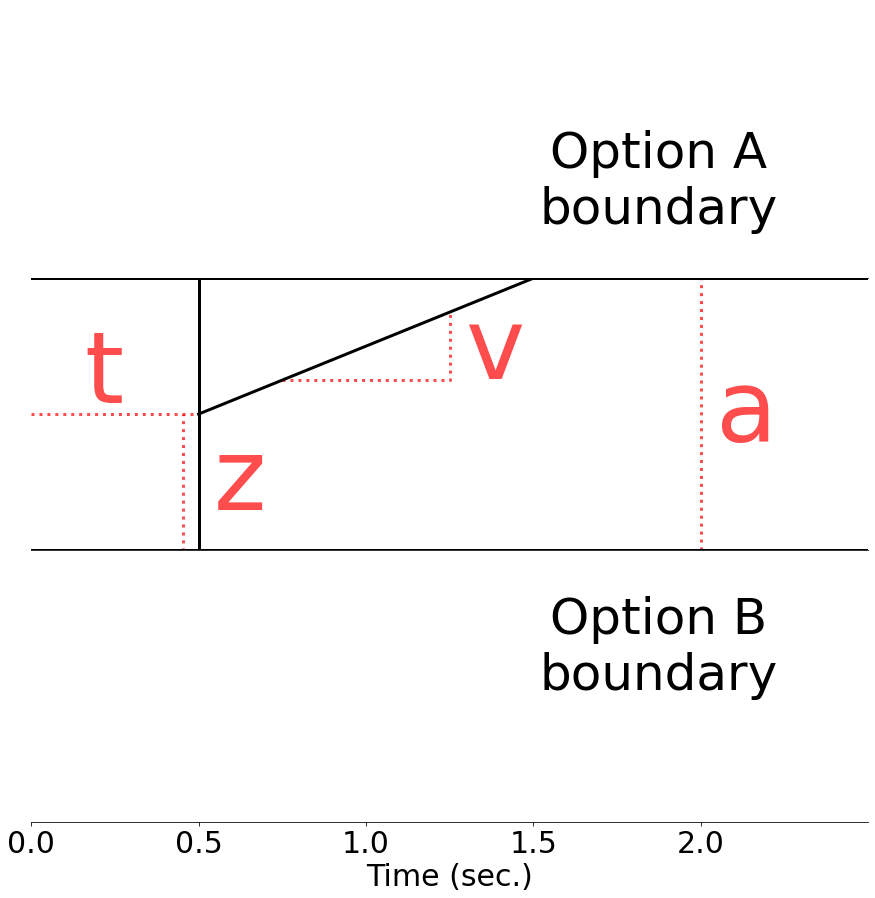

In [8]:
params ={'v':[0.25],'a':1,'t':0.5,'z':0.5}
tool.plot_model(params, xRange=(0,2.5), showParams=True,
           save=paths.ex_model_fig,
           response_names=('Option A\nboundary','Option B\nboundary' ))

In [9]:
stimCol = 'stim'
emp_data = RDM_model.data
nSets = 100

sim_RDM = tool.simdata(RDM_model, stimCol, nSets)


 [-----------------102%------------------] 38 of 37 complete in 21.6 sec

In [10]:
stimCol = 'emotion'
emp_data = FAD_model.data
nSets = 100

sim_FAD = tool.simdata(FAD_model, stimCol, nSets)


 [-----------------102%-----------------] 42 of 41 complete in 26.5 sec

2. Paper fig. 3B, RDM model

1.2358890211734892


No handles with labels found to put in legend.


341.25 341.25 0.0 0.0


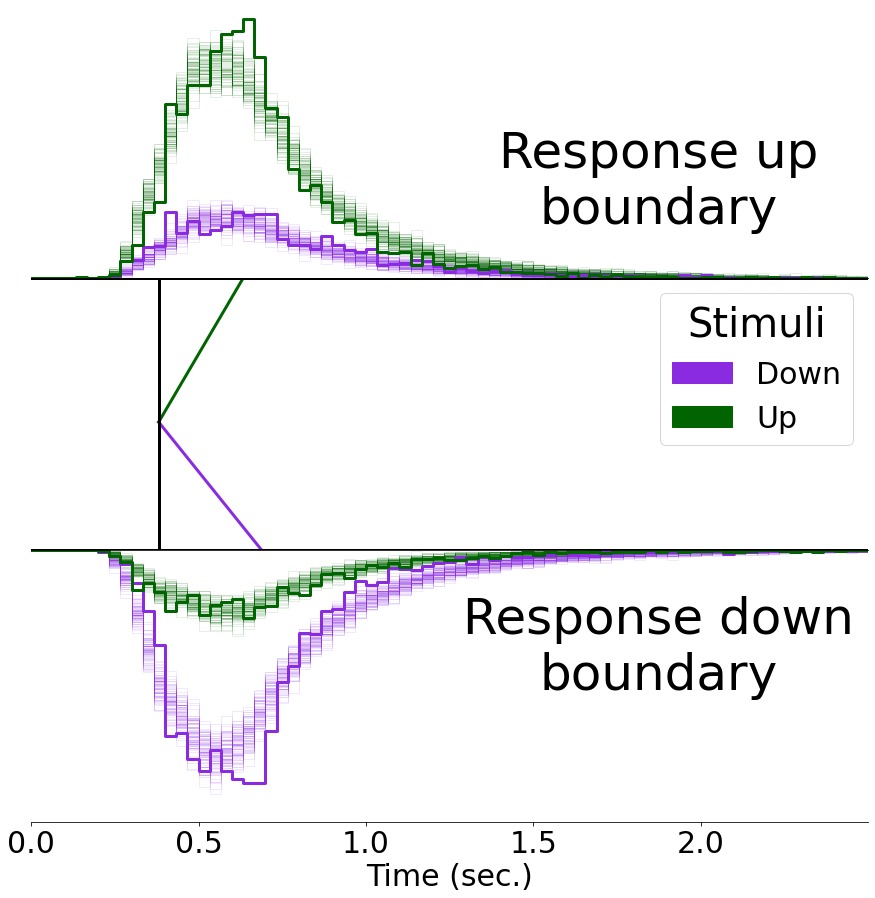

In [11]:
import importlib
importlib.reload(tool)

group_v_down = np.mean(RDM_model.nodes_db.node['v_C(stim, Treatment(0))[0]'].trace())
group_v_up = np.mean(RDM_model.nodes_db.node['v_C(stim, Treatment(0))[1]'].trace())


group_v_down = np.mean(RDM_model.nodes_db.node['v_C(stim, Treatment(0))[0]'].trace())
group_v_up = np.mean(RDM_model.nodes_db.node['v_C(stim, Treatment(0))[1]'].trace())

group_a = np.mean(RDM_model.nodes_db.node['a_Intercept'].trace())#['a_Intercept'].trace())
group_t = np.mean(RDM_model.nodes_db.node['t_Intercept'].trace())
group_z = np.mean(RDM_model.nodes_db.node['z_Intercept'].trace())

params ={'v':[group_v_down, group_v_up],'a':group_a,'t':group_t,'z':group_z,'sv':1}

emp_data = RDM_model.data
up_rts= np.array(emp_data.loc[emp_data.stim==1].rt)
down_rts= np.array(emp_data.loc[emp_data.stim==0].rt)




tool.plot_model(modelParams=params,
                xRange=(0,2.5),
                #yRange=(-1,1),
                rtDat=[down_rts, up_rts],
                ppc_rts = sim_RDM,
                showParams=False,
                vcol = ['blueviolet','darkgreen'],
                save=paths.rdm_model_fig_ppc,
                response_names=('Response up\nboundary','Response down\nboundary'),
                kws=0.3,
                bins=150,
                sim_alpha=0.1,
                legends=['Down', 'Up'])

# tool.plot_model(modelParams=params,
#                 xRange=(0,2.5),
#                 #yRange=(-1,1),
#                 #rtDat=[down_rts, up_rts],
#                 #ppc_rts = sim_RDM,
#                 #showParams=False,
#                 vcol = ['blueviolet','darkgreen'],
#                 save=None,#paths.rdm_model_fig,
#                 response_names=('Response up boundary','Response down boundary'),
#                 kws=0.3,
#                 bins=150,
#                 sim_alpha=0.1,
#                 legends=['Down', 'Up'])

3. Paper fig. 3C, FAD model

/home/malthe/Documents/git/The-respiratory-cycle-modulates-distinct-dynamics-of-affective-and-perceptual-decision-making
1.261643602921461


No handles with labels found to put in legend.


159.6 159.6 0.0 0.0


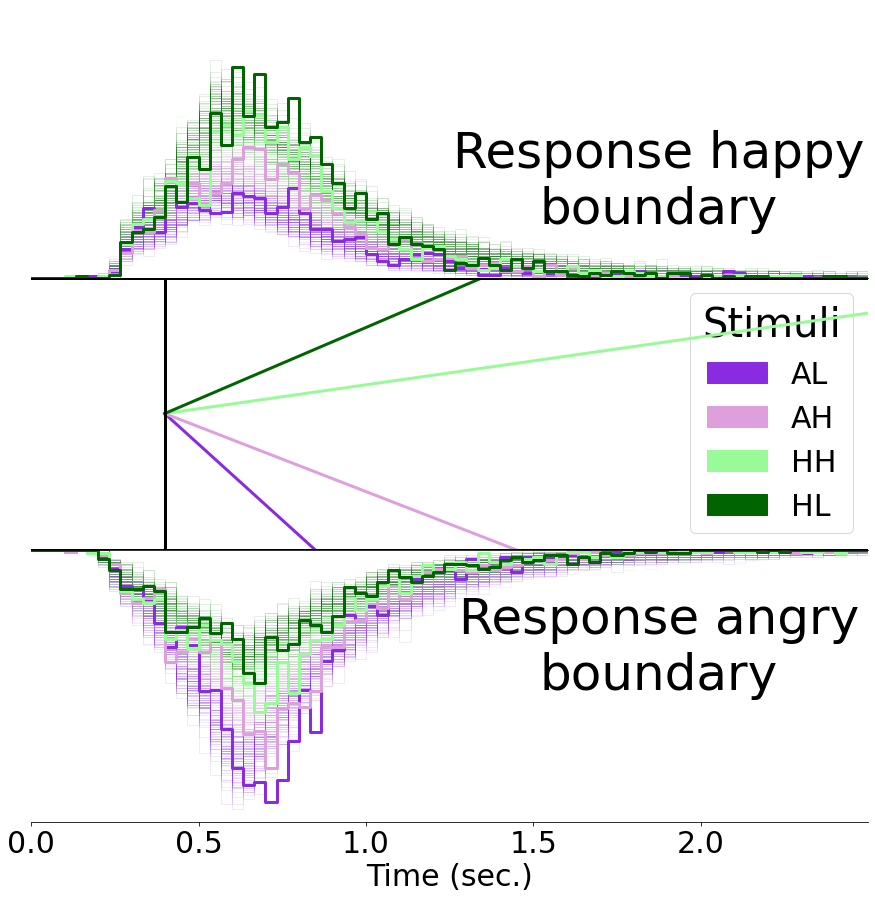

In [12]:
import importlib
importlib.reload(tool)
importlib.reload(paths)


group_v0 = np.mean(FAD_model.nodes_db.node['v_C(emotion, Treatment(0))[0]'].trace())
group_v1 = np.mean(FAD_model.nodes_db.node['v_C(emotion, Treatment(0))[1]'].trace())
group_v2 = np.mean(FAD_model.nodes_db.node['v_C(emotion, Treatment(0))[2]'].trace())
group_v3 = np.mean(FAD_model.nodes_db.node['v_C(emotion, Treatment(0))[3]'].trace())
group_a = np.mean(FAD_model.nodes_db.node['a_Intercept'].trace())
group_t = np.mean(FAD_model.nodes_db.node['t_Intercept'].trace())
group_z = np.mean(FAD_model.nodes_db.node['z_Intercept'].trace())


#FAD_params ={'v':[-0.8383454016517091,-0.32265392653035513,0.16765588498992398,0.4408518708130333],'a':1.0910675535524996,'t':0.48701364211975606,'z':0.4929919861735275,'sv':1}
FAD_params ={'v':[group_v0, group_v1, group_v2, group_v3],'a':group_a,'t':group_t,'z':group_z}#,'sv':1}
# FAD_params ={'v':[FAD_models_combined[m].nodes_db.node['v_C(emotion, Treatment(0))[0]'].trace(),
#                   FAD_models_combined[m].nodes_db.node['v_C(emotion, Treatment(0))[1]'].trace(),
#                   FAD_models_combined[m].nodes_db.node['v_C(emotion, Treatment(0))[2]'].trace(),
#                   FAD_models_combined[m].nodes_db.node['v_C(emotion, Treatment(0))[3]'].trace(),
#                   ],'a':group_a,'t':group_t,'z':group_z,'sv':1}

emp_data = FAD_model.data
e1 = np.array(emp_data.loc[emp_data.emotion == 0].rt)
e2 = np.array(emp_data.loc[emp_data.emotion == 1].rt)
e3 = np.array(emp_data.loc[emp_data.emotion == 2].rt)
e4 = np.array(emp_data.loc[emp_data.emotion == 3].rt)



tool.plot_model(FAD_params, xRange=(0,2.5), showParams=False,
           vcol=['blueviolet', 'plum', 'palegreen', 'darkgreen'], 
           save=paths.fad_model_fig_ppc,
           response_names=('Response happy\nboundary','Response angry\nboundary'),
           nSamps=5000,
           alphas={'v':0.01, 'a':0.003, 't':0.003},
           rtDat=[e1,e2,e3,e4],
           ppc_rts = sim_FAD,
           bins=150,
           sim_alpha=0.1,
           legends=['AL', 'AH', 'HH', 'HL'])
# tool.plot_model(FAD_params, xRange=(0,2.5), showParams=False,
#            vcol=['blueviolet', 'plum', 'palegreen', 'darkgreen'], 
#            #save=paths.fad_model_fig,
#            response_names=('Response happy boundary','Response angry boundary'),
#            nSamps=5000,
#            alphas={'v':0.01, 'a':0.003, 't':0.003},
#            #rtDat=[e1,e2,e3,e4],
#            #ppc_rts = sim_FAD,
#            bins=150,
#            sim_alpha=0.1,
#            legends=['AL', 'AH', 'HH', 'HL'])



# Paper fig. 3
Combined modelling

/home/malthe/Documents/git/The-respiratory-cycle-modulates-distinct-dynamics-of-affective-and-perceptual-decision-making/figures/paper_figs/ex_model.png
/home/malthe/Documents/git/The-respiratory-cycle-modulates-distinct-dynamics-of-affective-and-perceptual-decision-making/figures/paper_figs/rdm_model_ppc.png
/home/malthe/Documents/git/The-respiratory-cycle-modulates-distinct-dynamics-of-affective-and-perceptual-decision-making/figures/paper_figs/fad_model_ppc.png
/home/malthe/Documents/git/The-respiratory-cycle-modulates-distinct-dynamics-of-affective-and-perceptual-decision-making/figures/posteriors.png


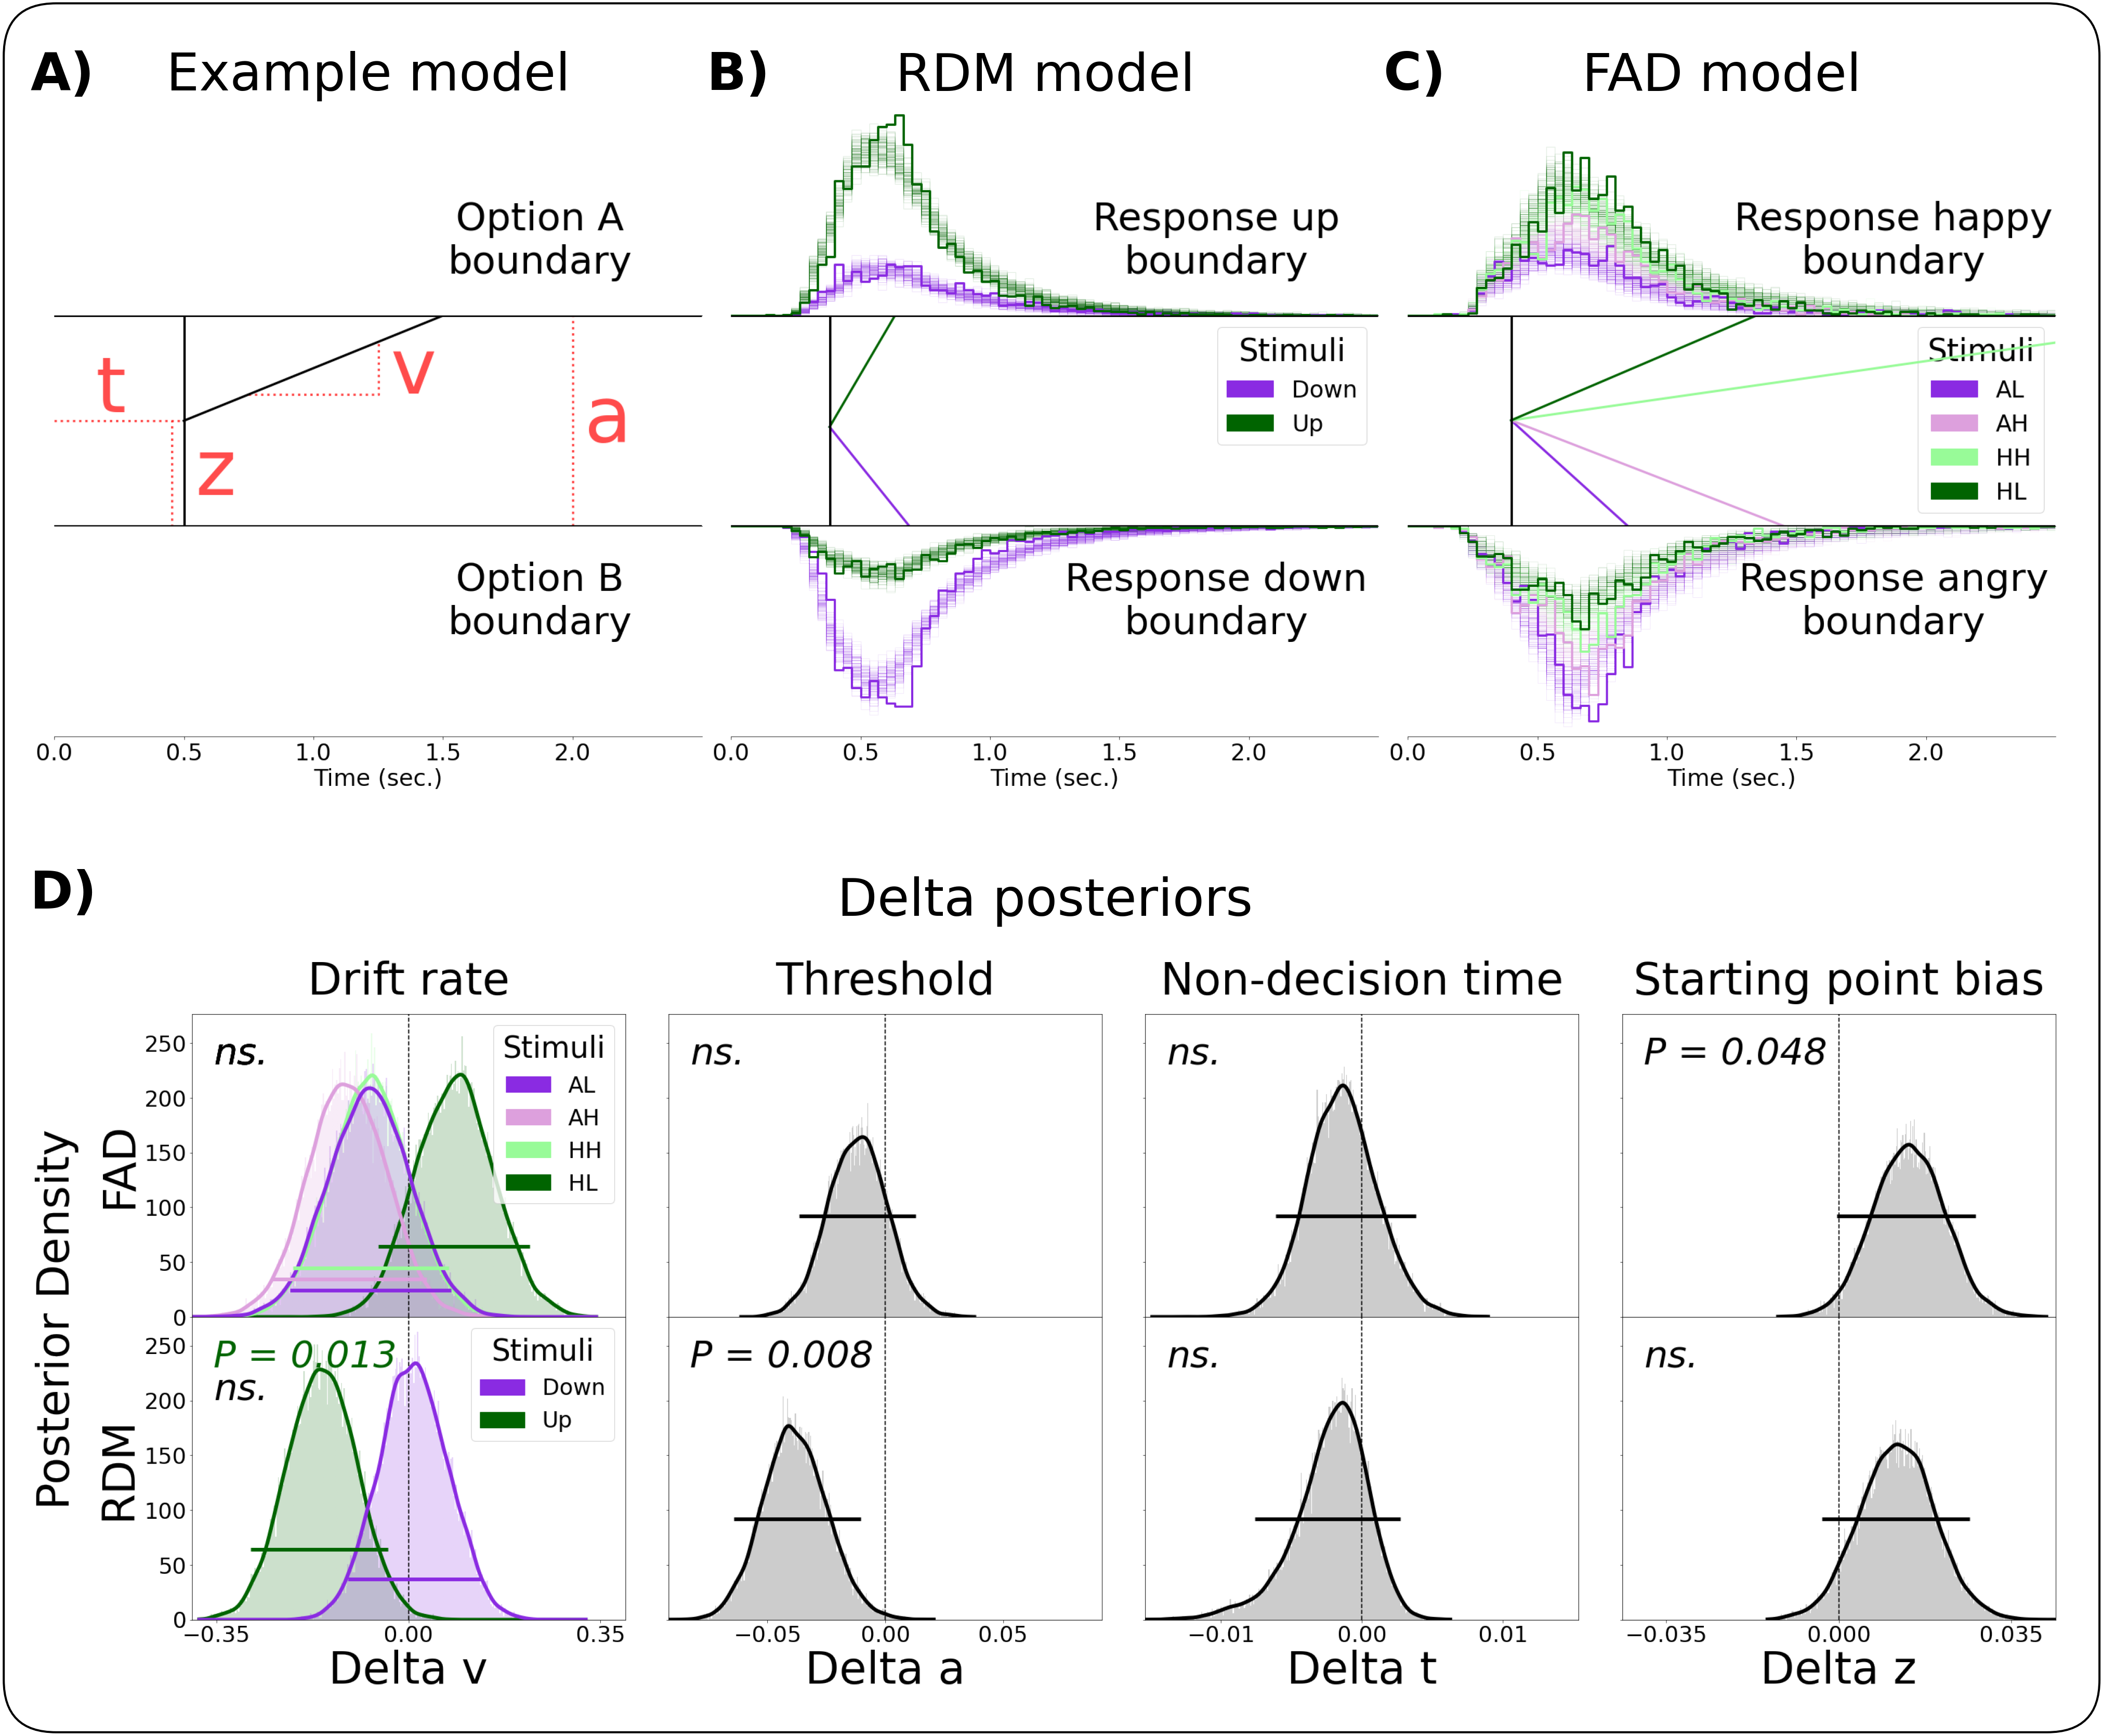

In [13]:
structure = [['moc', 'rdm', 'fad'],
             ['post', 'post', 'post']]
titel_size = 100


fig, axes = plt.subplot_mosaic(structure, figsize=(70, 70),
 gridspec_kw={ 'wspace':-0, 'hspace':-0.2,'width_ratios': [1,1,1] ,'height_ratios': [1,2]})#,, 'width_ratios': [1,2]

file0=paths.ex_model_fig
print(file0)
with cbook.get_sample_data(file0) as image_file:
    image = plt.imread(image_file)
im = axes['moc'].imshow(image)#, extent=(tIm,r,b,tIm), origin='lower')
axes['moc'].set_title('Example model', size = titel_size)

file0=paths.rdm_model_fig_ppc
print(file0)
with cbook.get_sample_data(file0) as image_file:
    image = plt.imread(image_file)
im = axes['rdm'].imshow(image)#, extent=(tIm,r,b,tIm), origin='lower')
axes['rdm'].set_title('RDM model', size = titel_size)

file0=paths.fad_model_fig_ppc
print(file0)
with cbook.get_sample_data(file0) as image_file:
    image = plt.imread(image_file)
im = axes['fad'].imshow(image)#, extent=(tIm,r,b,tIm), origin='lower')
axes['fad'].set_title('FAD model', size = titel_size)


file0=paths.post_combined_fig

print(file0)
with cbook.get_sample_data(file0) as image_file:
    image = plt.imread(image_file)
im = axes['post'].imshow(image)#, extent=(tIm,r,b,tIm), origin='lower')
axes['post'].set_title('Delta posteriors', size = titel_size, y=1.05)



for a in axes.values():
    #a.set_aspect('equal', adjustable='box')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.set_yticks([])
    a.set_xticks([])
    
# frame = mpatches.FancyBboxPatch((0.55, 0.425), -.08, .22, fill=False, color="k", lw=2, 
#                             zorder=1000, transform=fig.transFigure, figure=fig,
#                             boxstyle='round,rounding_size=0.02')
# frame.rounding_size=2

# fig.patches.extend([frame])
upy=-15
for a,letter, y in zip(['moc', 'rdm', 'fad', 'post'], ['A)','B)','C)', 'D)'], [upy,upy,upy,-65]):
    axes[a].text(-0.2, y, letter, 
            size=100, weight='bold')
    
frame = mpatches.FancyBboxPatch((0.415, 0.55), .2, .06, fill=False, color="k", lw=4, 
                            zorder=1000, transform=fig.transFigure, figure=fig,
                            boxstyle='round,rounding_size=0.02')
frame.rounding_size=2

fig.patches.extend([frame])
fig.patch.set_facecolor('white')
    
    
    
fig.savefig(paths.model_fig, bbox_inches='tight')

# MCMC chains

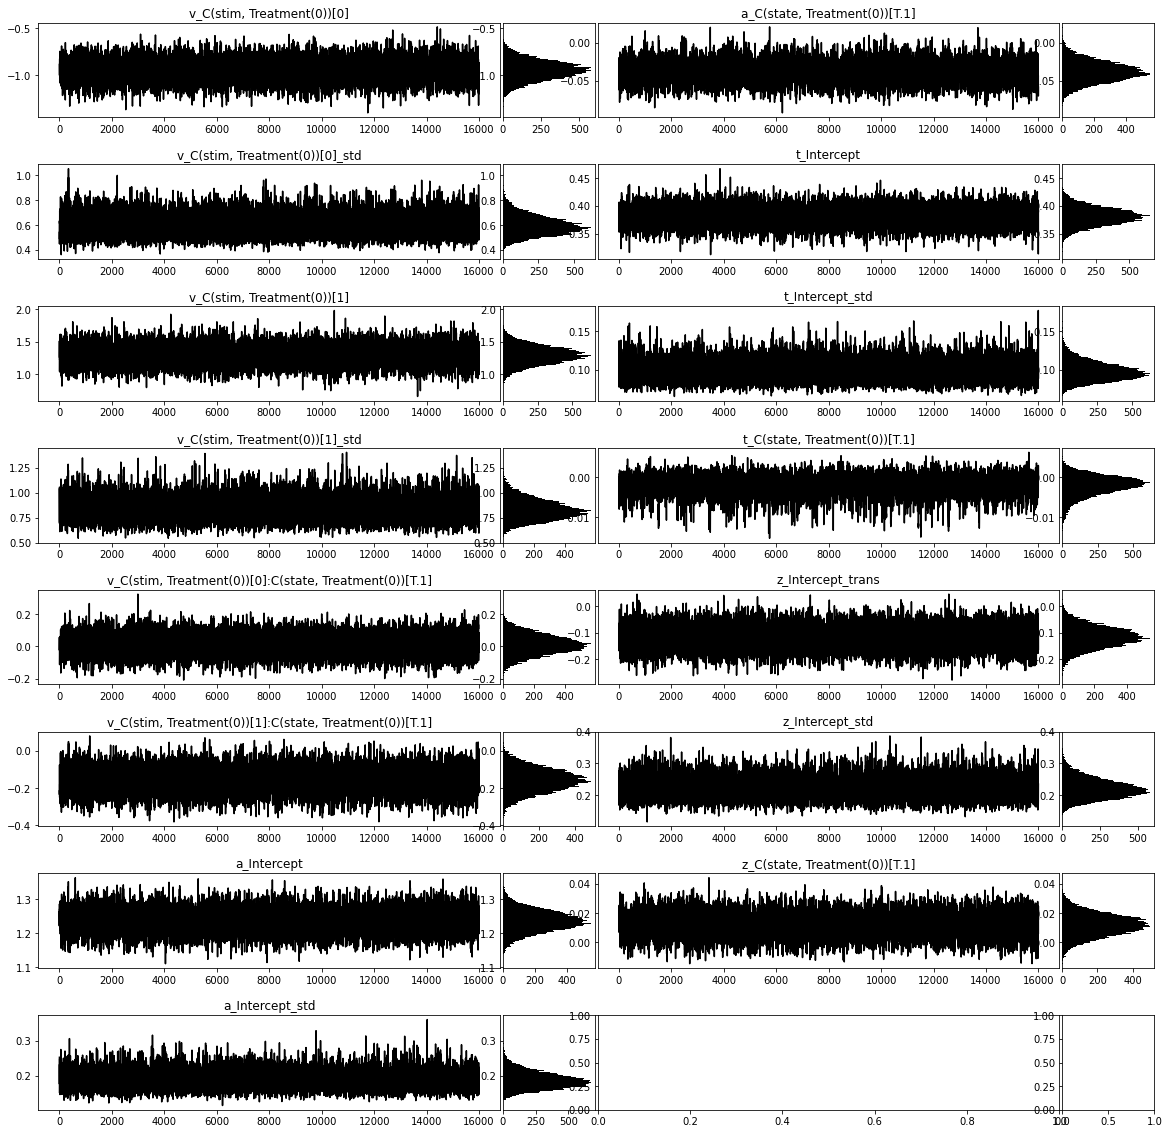

In [14]:
model = RDM_model
model_name = f'RDM_chains'


nodeNames = model.nodes_db.loc[
                            (model.nodes_db['subj']==False) &
                            (model.nodes_db['observed']==False)&
                            (model.nodes_db['stochastic']==True)
                            ].index

nNodes = len(nodeNames)


nrows = nNodes//2+1

fig, axes = plt.subplots(ncols=4, nrows=nrows,  sharex=False, figsize=(20, 20),
                        gridspec_kw={'wspace':0.01, 'hspace':0.5, 'width_ratios':[5,1,5,1]},
                        )
#fig.suptitle(f'{model_name}')

for name, i in zip(nodeNames, range(nNodes)):
    axes[i%nrows,i//nrows*2].plot(model.nodes_db.node[name].trace(), color = 'k', alpha=1)
    axes[i%nrows,i//nrows*2 + 1].hist(model.nodes_db.node[name].trace(), color = 'k', alpha=1,
                orientation='horizontal', bins=100)


    axes[i%nrows,i//nrows*2].set_title(name)
fig.savefig(paths.supplementary_figs / f'{model_name}.png')

Index(['v_C(emotion, Treatment(0))[0]', 'v_C(emotion, Treatment(0))[0]_std',
       'v_C(emotion, Treatment(0))[1]', 'v_C(emotion, Treatment(0))[1]_std',
       'v_C(emotion, Treatment(0))[2]', 'v_C(emotion, Treatment(0))[2]_std',
       'v_C(emotion, Treatment(0))[3]', 'v_C(emotion, Treatment(0))[3]_std',
       'v_C(emotion, Treatment(0))[0]:C(state, Treatment(0))[T.1]',
       'v_C(emotion, Treatment(0))[1]:C(state, Treatment(0))[T.1]',
       'v_C(emotion, Treatment(0))[2]:C(state, Treatment(0))[T.1]',
       'v_C(emotion, Treatment(0))[3]:C(state, Treatment(0))[T.1]',
       'a_Intercept', 'a_Intercept_std', 'a_C(state, Treatment(0))[T.1]',
       't_Intercept', 't_Intercept_std', 't_C(state, Treatment(0))[T.1]',
       'z_Intercept_trans', 'z_Intercept_std',
       'z_C(state, Treatment(0))[T.1]'],
      dtype='object')


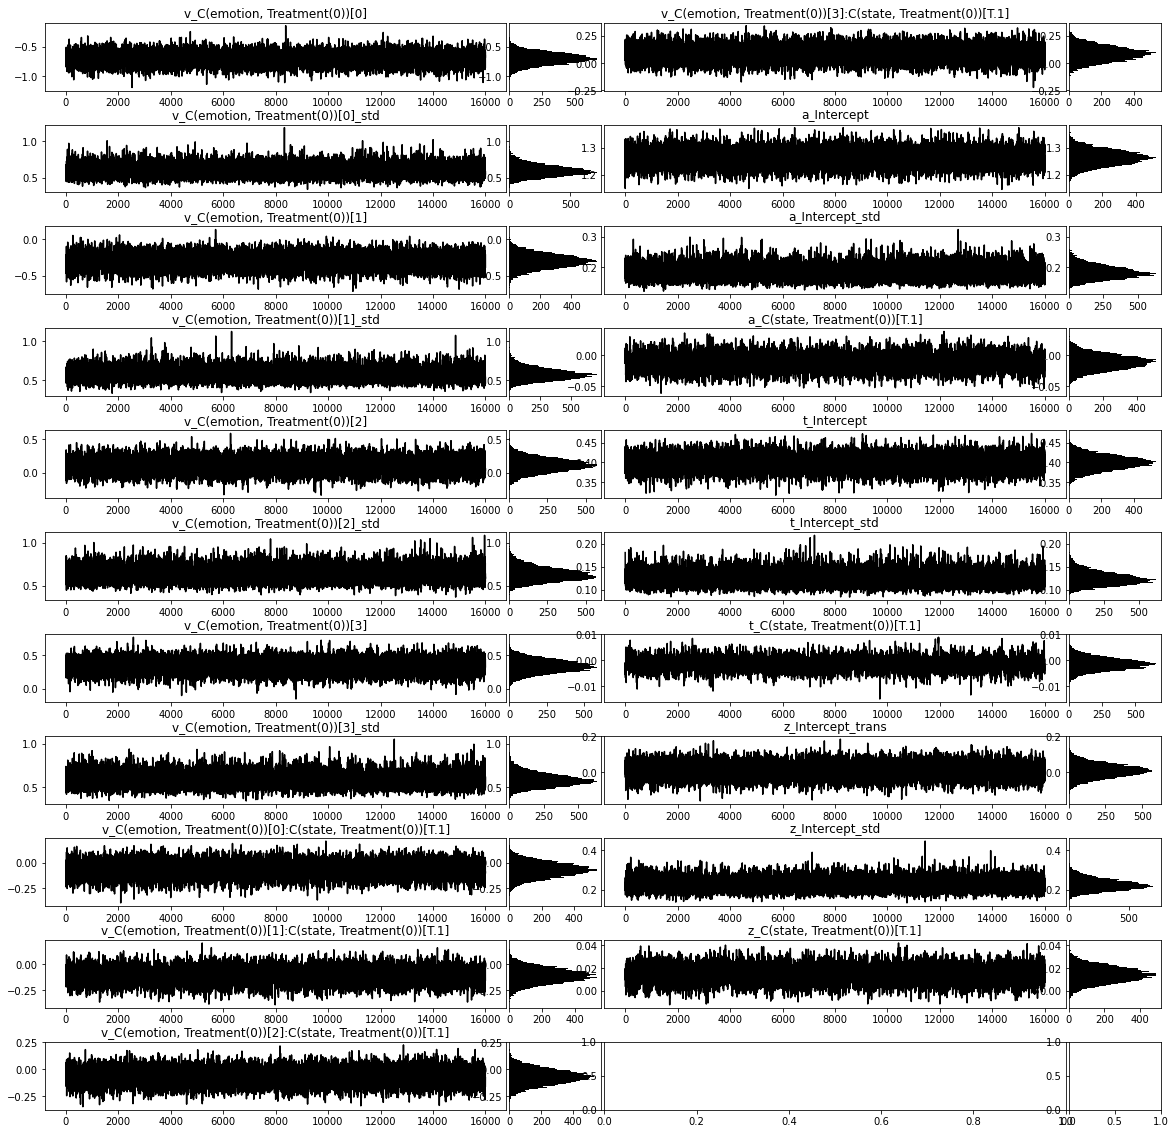

In [15]:

model = FAD_model
model_name = f'FAD_chains'


nodeNames = model.nodes_db.loc[
                            (model.nodes_db['subj']==False) &
                            (model.nodes_db['observed']==False)&
                            (model.nodes_db['stochastic']==True)
                            ].index


nNodes = len(nodeNames)

print(nodeNames)

nrows = nNodes//2+1

fig, axes = plt.subplots(ncols=4, nrows=nrows,  sharex=False, figsize=(20, 20),
                        gridspec_kw={'wspace':0.01, 'hspace':0.5, 'width_ratios':[5,1,5,1]},
                        )
#fig.suptitle(f'{model_name}')

for name, i in zip(nodeNames, range(nNodes)):
    axes[i%nrows,i//nrows*2].plot(model.nodes_db.node[name].trace(), color = 'k', alpha=1)
    axes[i%nrows,i//nrows*2 + 1].hist(model.nodes_db.node[name].trace(), color = 'k', alpha=1,
                orientation='horizontal', bins=100)


    axes[i%nrows,i//nrows*2].set_title(name)
fig.savefig(paths.supplementary_figs / f'{model_name}.png')

# Fig. s2

/home/malthe/Documents/git/The-respiratory-cycle-modulates-distinct-dynamics-of-affective-and-perceptual-decision-making/figures/supplementary/RDM_chains.png
/home/malthe/Documents/git/The-respiratory-cycle-modulates-distinct-dynamics-of-affective-and-perceptual-decision-making/figures/supplementary/FAD_chains.png


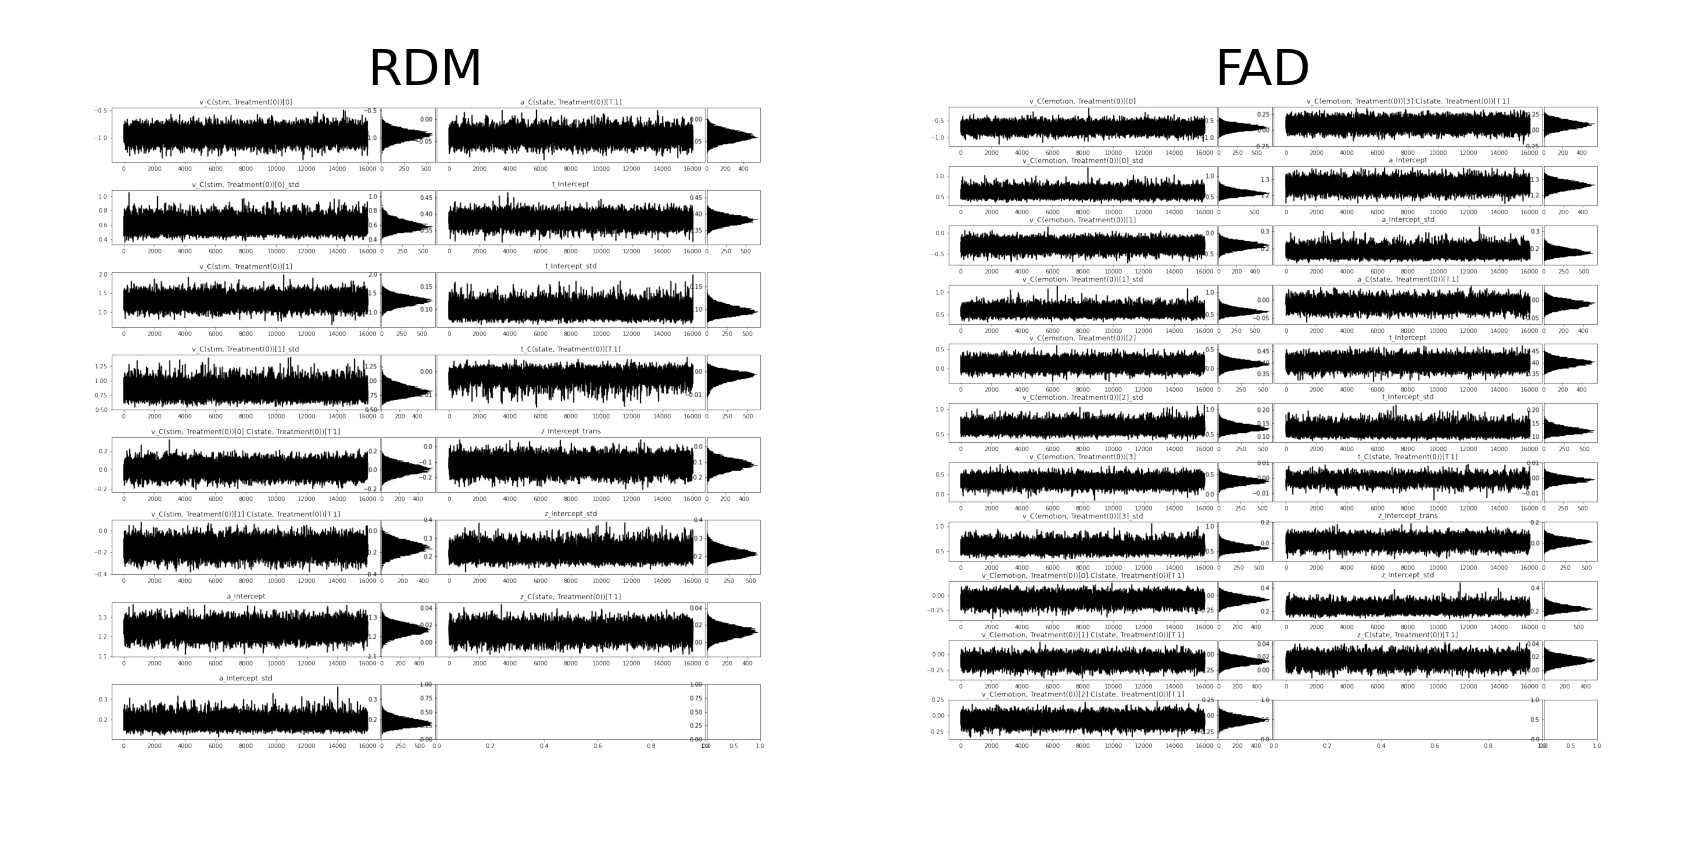

In [16]:
structure = ['RDM_chains.png','FAD_chains.png']



fig, axes = plt.subplot_mosaic([structure], figsize=(30, 20),
 gridspec_kw={ 'wspace':0.0, 'hspace':0.0, 'height_ratios': [1], 'width_ratios': [1,1]})#,'height_ratios': [1,1],, 'width_ratios': [1,2]
#fig.tight_layout( rect=[0.00, 0.00, 1, 1])
#fig.tight_layout(rect=[0, 0.00, .7, 1])

for im in range(len(structure)):
    file0= paths.supplementary_figs / structure[im]
    print(file0)
    with cbook.get_sample_data(file0) as image_file:
        image = plt.imread(image_file)
    ima = axes[structure[im]].imshow(image)#, extent=(tIm,r,b,tIm), origin='lower')
    axes[structure[im]].set_title(structure[im][:3], size=50, y=0.9)


for a in axes.values():
    #a.set_aspect('equal', adjustable='box')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.set_yticks([])
    a.set_xticks([])
    
# axes['RDM_hypo'].set_ylabel('RDM', size=50)
# axes['FAD_hypo'].set_ylabel('FAD', size=50)

# axes['RDM_hypo'].set_title('Hypo', size=50)
# axes['RDM_null'].set_title('Null', size=50)
# axes['RDM_temp'].set_title('Full', size=50)

fig.savefig(paths.supplementary_figs / f'combined_traces.png',bbox_inches='tight')